# QOSF Mentorship II 
## Task 1

![1.png](images/1.png)

### I've chosen to work in Qiskit and to attempt as much of this from scratch as possible.

In [82]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit import Aer, execute
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import *
import numpy as np
import random
from qiskit_tools import array_to_latex
import matplotlib.pyplot as plt
import time

qubits = 4

![2.png](images/2.png)

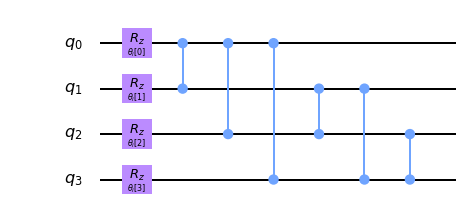

In [14]:
def generate_even_block(theta : ParameterVector):
    width = len(theta)
    qc = QuantumCircuit(width)
    for i, t in enumerate(theta.params):
        qc.rz(t, i)
    for i in range(width):
        for j in range(i+1, width):
            qc.cz(i, j)
    return qc

theta = ParameterVector(f"$\\theta_i$", qubits)
qc = generate_even_block(theta)
qc.draw(output='mpl')

![3.png](images/3.png)

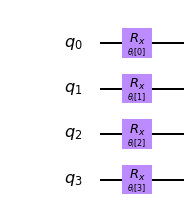

In [13]:
def generate_odd_block(theta : ParameterVector):
    width = len(theta)
    qc = QuantumCircuit(width)
    for i, t in enumerate(theta.params):
        qc.rx(t, i)
    return qc

qc = generate_odd_block(theta)
qc.draw(output='mpl')

In [6]:
def get_random_parameters_in_range(parameters, start, stop):
    assigned_params = {}
    for p in sorted(parameters, key=lambda p: p.name):
        assigned_params[p] = random.uniform(start, stop)
    return assigned_params

get_random_parameters_in_range(qc.parameters, 0, 2 * np.pi)

{Parameter($\theta_i$[0]): 1.9973309475325702,
 Parameter($\theta_i$[1]): 1.253705455464039,
 Parameter($\theta_i$[2]): 0.6398839247215546,
 Parameter($\theta_i$[3]): 5.886288512336208}

### Now, let's put it all together for the full state preparation circuit (still parameterized though):

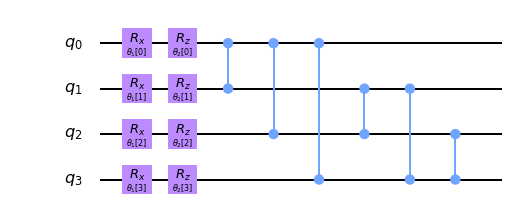

In [15]:
def generate_state_preparation_circuit(width, L):
    qc = QuantumCircuit(width)
    i = 0
    for layer in range(L):
        i = i + 1
        theta = ParameterVector(f"$\\theta_{i}$", width)
        qc += generate_odd_block(theta)        
        i = i + 1
        theta = ParameterVector(f"$\\theta_{i}$", width)
        qc += generate_even_block(theta)
    return qc

qc = generate_state_preparation_circuit(4, 1)
qc.draw(output='mpl')

![4.png](images/4.png)

|phi> = [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
||phi|| = 1.0



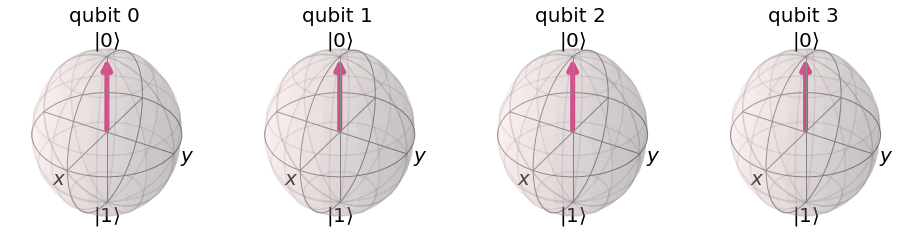

|psi> = [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
||psi|| = 1.0



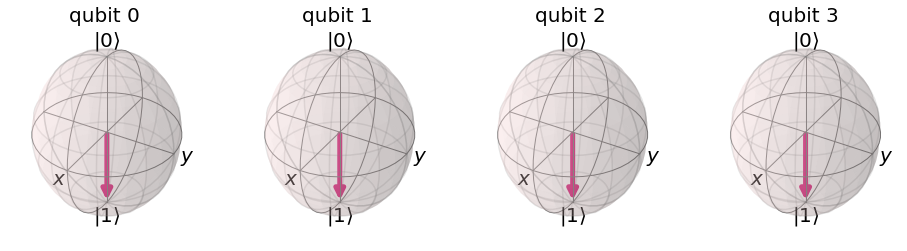

||psi - phi|| = 2.0


In [58]:
def norm(sv):    
    return np.sum(sv.conjugate().data * sv.data).real

phi = Statevector([1, 0]).tensor(Statevector([1, 0])).tensor(Statevector([1, 0])).tensor(Statevector([1, 0]))
print(f'|phi> = {np.around(phi.data, 1)}\n||phi|| = {norm(phi)}\n')
display(plot_bloch_multivector(phi.data))
psi = Statevector([0, 1]).tensor(Statevector([0, 1])).tensor(Statevector([0, 1])).tensor(Statevector([0, 1]))
print(f'|psi> = {np.around(psi.data, 1)}\n||psi|| = {norm(psi)}\n')
display(plot_bloch_multivector(psi.data))
print(f'||psi - phi|| = {norm(psi - phi)}')

### For gradient descent, let's try using the [parameter shift approach](https://pennylane.ai/qml/glossary/parameter_shift.html) from Schuld, et. al.

In [56]:
def gradient_param_shift(target, qc, params):
    params_gradient = {}
    qubit_count = qc.num_qubits
    for p, v in params.items():
        # we work with a copy, so that we can differentiate w.r.t. a single param at a time
        params_shift = params.copy()

        # for pauli operators we can apply +/- pi/2
        v_plus = v + np.pi/2
        params_shift[p] = v_plus
        qc_bound = qc.assign_parameters(params_shift, inplace=False)
        psi_plus = Statevector.from_instruction(qc_bound)

        v_neg = v - np.pi/2
        params_shift[p] = v_neg
        qc_bound = qc.assign_parameters(params_shift, inplace=False)
        psi_neg = Statevector.from_instruction(qc_bound)

#         print(psi_plus - psi_neg)
        params_gradient[p] = 0.5 * (norm(psi_plus - target) - norm(psi_neg - target))
    return params_gradient

### Let's try training (briefly) our circuit parameters to approxmiate a random state $|\phi\rangle$ and compare different learning rates.

|phi> = [-0.2+0.1j -0.1+0.j  -0.2-0.3j  0.4-0.2j  0.3+0.1j  0.1+0.1j  0. -0.1j
 -0.2+0.1j  0.1-0.3j -0.1-0.j  -0.1+0.j   0.3-0.1j -0.2+0.2j -0.1-0.2j
 -0.2-0.j   0.2+0.1j]


Training with 1 layer(s) using 10 iterations and 0.1 learning rate:
Iteration    0 => Loss: 1.8873503548
Iteration    9 => Loss: 1.5879384736
Completed in 0.7 seconds


Training with 2 layer(s) using 10 iterations and 0.1 learning rate:
Iteration    0 => Loss: 2.4285553549
Iteration    9 => Loss: 1.7483062657
Completed in 2.6 seconds


Training with 3 layer(s) using 10 iterations and 0.1 learning rate:
Iteration    0 => Loss: 1.9808481460
Iteration    9 => Loss: 1.0160272721
Completed in 5.8 seconds


Training with 4 layer(s) using 10 iterations and 0.1 learning rate:
Iteration    0 => Loss: 2.0548129683
Iteration    9 => Loss: 1.2705427502
Completed in 10.2 seconds


Training with 1 layer(s) using 10 iterations and 0.01 learning rate:
Iteration    0 => Loss: 1.8873503548
Iteration    9 => Loss: 1.8563101375
Comple

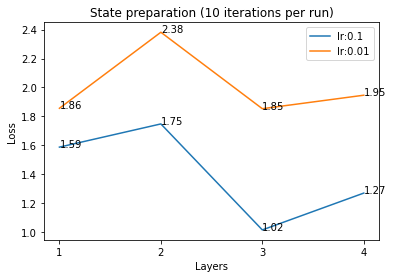

In [91]:
def train(target, qc, params, iterations, learning_rate, print_modulus=None):
    if print_modulus is None:
        print_modulus = max(iterations / 10, 10) # print every so often
    psi = None
    for i in range(iterations):
        qc_bound = qc.assign_parameters(params, inplace=False)
        psi = Statevector.from_instruction(qc_bound)
        params_gradient = gradient_param_shift(target, qc, params)
        
        if i % print_modulus == 0 or i == iterations - 1:
            print("Iteration %4d => Loss: %.10f" % (i, norm(psi - target)))

        # Update the parameters by descending along the gradient
        for p, v in params.items():
            params[p] = v - params_gradient[p] * learning_rate
                        
    return (params, psi, norm(psi - target))


phi = random_statevector(2 ** qubits, seed=19)
print(f'|phi> = {np.around(phi.data, 1)}')

layers = range(1, 4 + 1)
results = {}
iterations = 10

for lr in [0.1, 0.01]:
    losses = []
    for l in layers:
        print(f"\n\nTraining with {l} layer(s) using {iterations} iterations and {lr} learning rate:")
        qc = generate_state_preparation_circuit(qubits, l)
        random.seed(42)
        random_params = get_random_parameters_in_range(qc.parameters, 0, 2 * np.pi)
        start_time = time.time()
        (final_params, psi, loss) = train(phi, qc, random_params, iterations, lr)
        end_time = time.time()
        diff_time = end_time - start_time
        print(f'Completed in {np.around(diff_time, 1)} seconds')
        losses.append(loss)
    results[lr] = losses.copy()
    
plt.title(f'State preparation ({iterations} iterations per run)')
for lr, losses in results.items():
    plt.plot(layers, losses, label=f"lr:{lr}")
    for i in range(len(losses)): plt.annotate(np.around(losses[i], 2), (layers[i], losses[i]))
plt.xlabel("Layers")
plt.ylabel("Loss")
plt.xticks(layers)
plt.legend()
plt.show()

### Let's stick with a learning rate of 0.1 and try with more layers and iterations, but let's stop if we hit a [barren plateau](https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html).



Training with 1 layer(s) using 1000 iterations and 0.1 learning rate:
Iteration    0 => Loss: 1.8873503548
Iteration  100 => Loss: 0.6165497798
Iteration  200 => Loss: 0.5269796594
Reached barren plateau!
Iteration  222 => Loss: 0.5244657265
Completed in 15.7 seconds


Training with 2 layer(s) using 1000 iterations and 0.1 learning rate:
Iteration    0 => Loss: 2.4285553549
Iteration  100 => Loss: 0.5932438200
Iteration  200 => Loss: 0.2427542444
Reached barren plateau!
Iteration  266 => Loss: 0.2024701544
Completed in 69.3 seconds


Training with 3 layer(s) using 1000 iterations and 0.1 learning rate:
Iteration    0 => Loss: 1.9808481460
Iteration  100 => Loss: 0.1668145409
Iteration  200 => Loss: 0.1301038545
Iteration  300 => Loss: 0.1038422246
Reached barren plateau!
Iteration  322 => Loss: 0.0988313033
Completed in 185.6 seconds


Training with 4 layer(s) using 1000 iterations and 0.1 learning rate:
Iteration    0 => Loss: 2.0548129683
Iteration  100 => Loss: 0.2818047994
Iterat

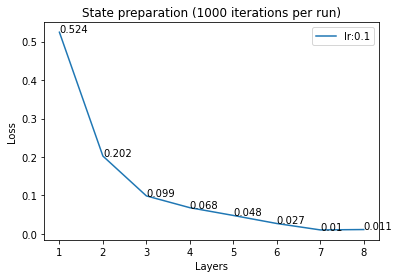

In [96]:
def train_stop_on_barren(target, qc, params, iterations, learning_rate, print_modulus=None):
    if print_modulus is None:
        print_modulus = max(iterations / 10, 10) # print every so often
    psi = None
    for i in range(iterations):
        qc_bound = qc.assign_parameters(params, inplace=False)
        psi = Statevector.from_instruction(qc_bound)
        params_gradient = gradient_param_shift(target, qc, params)
        params_gradient_list = list(params_gradient.values())
        params_gradient_variance = np.var(params_gradient_list)
        
        force_print = False
        stop_training = False
        if params_gradient_variance < 0.0001:
            print("Reached barren plateau!")
            force_print = True
            stop_training = True
        
        if i % print_modulus == 0 or i == iterations - 1 or force_print:
            print("Iteration %4d => Loss: %.10f" % (i, norm(psi - target)))
            
        for p, v in params.items():
            params[p] = v - params_gradient[p] * learning_rate
            
        if stop_training:
            break
            
    return (params, psi, norm(psi - target))

layers = range(1, 8 + 1)
results = {}
iterations = 1000

for lr in [0.1]:
    losses = []
    for l in layers:
        print(f"\n\nTraining with {l} layer(s) using {iterations} iterations and {lr} learning rate:")
        qc = generate_state_preparation_circuit(qubits, l)
        random.seed(42)
        random_params = get_random_parameters_in_range(qc.parameters, 0, 2 * np.pi)
        start_time = time.time()
        (final_params, psi, loss) = train_stop_on_barren(phi, qc, random_params, iterations, lr, print_modulus=100)
        end_time = time.time()
        diff_time = end_time - start_time
        print(f'Completed in {np.around(diff_time, 1)} seconds')
        losses.append(loss)
    results[lr] = losses.copy()
    
plt.title(f'State preparation ({iterations} iterations per run)')
for lr, losses in results.items():
    plt.plot(layers, losses, label=f"lr:{lr}")
    for i in range(len(losses)): plt.annotate(np.around(losses[i], 3), (layers[i], losses[i]))
plt.xlabel("Layers")
plt.ylabel("Loss")
plt.xticks(layers)
plt.legend()
plt.show()

### It seems that using 5 layers has a good trade-off for loss minimization (0.048) and training time (169.7 s). Let's continue with some more experimentation here.

![5.png](images/5.png)



Training with 5 layer(s) using 1000 iterations and 0.1 learning rate:
Iteration    0 => Loss: 1.7717165056
Iteration  100 => Loss: 0.1712390128
Reached barren plateau!
Iteration  180 => Loss: 0.0577946159
Completed in 321.5 seconds


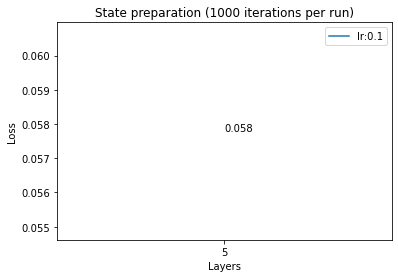

In [102]:
def generate_state_preparation_circuit_swap_blocks(width, L):
    qc = QuantumCircuit(width)
    i = 0
    for layer in range(L):
        i = i + 1
        theta = ParameterVector(f"$\\theta_{i}$", width)
        qc += generate_even_block(theta)
        i = i + 1
        theta = ParameterVector(f"$\\theta_{i}$", width)
        qc += generate_odd_block(theta)        
    return qc

layers = [5]
results = {}
iterations = 1000

for lr in [0.1]:
    losses = []
    for l in layers:
        print(f"\n\nTraining with {l} layer(s) using {iterations} iterations and {lr} learning rate:")
        qc = generate_state_preparation_circuit_swap_blocks(qubits, l)
        random.seed(42)
        random_params = get_random_parameters_in_range(qc.parameters, 0, 2 * np.pi)
        start_time = time.time()
        (final_params, psi, loss) = train_stop_on_barren(phi, qc, random_params, iterations, lr, print_modulus=100)
        end_time = time.time()
        diff_time = end_time - start_time
        print(f'Completed in {np.around(diff_time, 1)} seconds')
        losses.append(loss)
    results[lr] = losses.copy()
    
plt.title(f'State preparation ({iterations} iterations per run)')
for lr, losses in results.items():
    plt.plot(layers, losses, label=f"lr:{lr}")
    for i in range(len(losses)): plt.annotate(np.around(losses[i], 3), (layers[i], losses[i]))
plt.xlabel("Layers")
plt.ylabel("Loss")
plt.xticks(layers)
plt.legend()
plt.show()

### Swapping the odd and even blocks doesn't seem to produce any significantly better results. Let's try swapping RX and RZ gates and replace the CZ gates with CX.

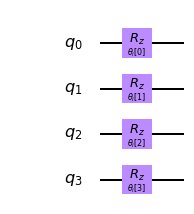

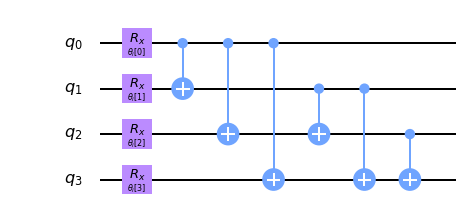

In [105]:
def generate_even_block_swapped(theta : ParameterVector):
    width = len(theta)
    qc = QuantumCircuit(width)
    for i, t in enumerate(theta.params):
        qc.rx(t, i)
    for i in range(width):
        for j in range(i+1, width):
            qc.cx(i, j)
    return qc

def generate_odd_block_swapped(theta : ParameterVector):
    width = len(theta)
    qc = QuantumCircuit(width)
    for i, t in enumerate(theta.params):
        qc.rz(t, i)
    return qc

qc = generate_odd_block_swapped(theta)
display(qc.draw(output='mpl'))
theta = ParameterVector(f"$\\theta_i$", qubits)
qc = generate_even_block_swapped(theta)
display(qc.draw(output='mpl'))



Training with 5 layer(s) using 1000 iterations and 0.1 learning rate:
Iteration    0 => Loss: 2.9099370108
Iteration  100 => Loss: 0.1070025468
Reached barren plateau!
Iteration  185 => Loss: 0.0302486369
Completed in 194.4 seconds


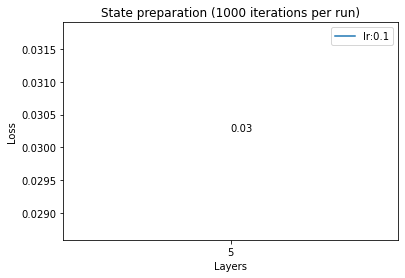

In [106]:
def generate_state_preparation_circuit_swap_gates(width, L):
    qc = QuantumCircuit(width)
    i = 0
    for layer in range(L):
        i = i + 1
        theta = ParameterVector(f"$\\theta_{i}$", width)
        qc += generate_odd_block_swapped(theta)        
        i = i + 1
        theta = ParameterVector(f"$\\theta_{i}$", width)
        qc += generate_even_block_swapped(theta)
    return qc

layers = [5]
results = {}
iterations = 1000

for lr in [0.1]:
    losses = []
    for l in layers:
        print(f"\n\nTraining with {l} layer(s) using {iterations} iterations and {lr} learning rate:")
        qc = generate_state_preparation_circuit_swap_gates(qubits, l)
        random.seed(42)
        random_params = get_random_parameters_in_range(qc.parameters, 0, 2 * np.pi)
        start_time = time.time()
        (final_params, psi, loss) = train_stop_on_barren(phi, qc, random_params, iterations, lr, print_modulus=100)
        end_time = time.time()
        diff_time = end_time - start_time
        print(f'Completed in {np.around(diff_time, 1)} seconds')
        losses.append(loss)
    results[lr] = losses.copy()
    
plt.title(f'State preparation ({iterations} iterations per run)')
for lr, losses in results.items():
    plt.plot(layers, losses, label=f"lr:{lr}")
    for i in range(len(losses)): plt.annotate(np.around(losses[i], 3), (layers[i], losses[i]))
plt.xlabel("Layers")
plt.ylabel("Loss")
plt.xticks(layers)
plt.legend()
plt.show()

### We have a slightly better result (0.030) over the original circuit (0.048) at 5 layers. Let's kick off one last run with no early termination. 



Training with 5 layer(s) using 1000 iterations and 0.1 learning rate:
Iteration    0 => Loss: 2.9099370108
Iteration  100 => Loss: 0.1070025468
Iteration  200 => Loss: 0.0256738288
Iteration  300 => Loss: 0.0105187354
Iteration  400 => Loss: 0.0055351198
Iteration  500 => Loss: 0.0034053032
Iteration  600 => Loss: 0.0023066777
Iteration  700 => Loss: 0.0016349857
Iteration  800 => Loss: 0.0011770015
Iteration  900 => Loss: 0.0008502112
Iteration  999 => Loss: 0.0006163949
Completed in 1050.1 seconds


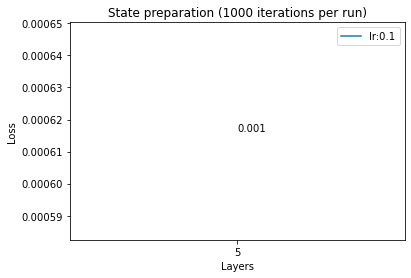

In [107]:
layers = [5]
results = {}
iterations = 1000

for lr in [0.1]:
    losses = []
    for l in layers:
        print(f"\n\nTraining with {l} layer(s) using {iterations} iterations and {lr} learning rate:")
        qc = generate_state_preparation_circuit_swap_gates(qubits, l)
        random.seed(42)
        random_params = get_random_parameters_in_range(qc.parameters, 0, 2 * np.pi)
        start_time = time.time()
        (final_params, psi, loss) = train(phi, qc, random_params, iterations, lr, print_modulus=100)
        end_time = time.time()
        diff_time = end_time - start_time
        print(f'Completed in {np.around(diff_time, 1)} seconds')
        losses.append(loss)
    results[lr] = losses.copy()
    
plt.title(f'State preparation ({iterations} iterations per run)')
for lr, losses in results.items():
    plt.plot(layers, losses, label=f"lr:{lr}")
    for i in range(len(losses)): plt.annotate(np.around(losses[i], 3), (layers[i], losses[i]))
plt.xlabel("Layers")
plt.ylabel("Loss")
plt.xticks(layers)
plt.legend()
plt.show()

### We've been able to approximate $|\phi\rangle$ with only a loss of 0.0006. Seems pretty good to me! As a sanity check I went back and re-ran all previous layers to 1000 iterations and found that the same level of loss was unreachable with fixed iterations. They all seem to level out, so I'm doubtful that any more iterations (e.g. 10,000) would have lower loss. I've included my final sanity check (i.e. level 4) below.



Training with 4 layer(s) using 1000 iterations and 0.1 learning rate:
Iteration    0 => Loss: 1.2175263919
Iteration  100 => Loss: 0.0841417513
Iteration  200 => Loss: 0.0631526267
Iteration  300 => Loss: 0.0559889741
Iteration  400 => Loss: 0.0518815533
Iteration  500 => Loss: 0.0481919984
Iteration  600 => Loss: 0.0440684823
Iteration  700 => Loss: 0.0395870271
Iteration  800 => Loss: 0.0353570701
Iteration  900 => Loss: 0.0318849204
Iteration  999 => Loss: 0.0292695200
Completed in 696.2 seconds


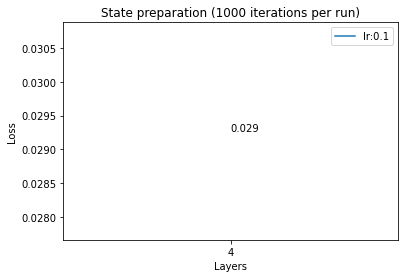

In [111]:
layers = [4]
results = {}
iterations = 1000

for lr in [0.1]:
    losses = []
    for l in layers:
        print(f"\n\nTraining with {l} layer(s) using {iterations} iterations and {lr} learning rate:")
        qc = generate_state_preparation_circuit_swap_gates(qubits, l)
        random.seed(42)
        random_params = get_random_parameters_in_range(qc.parameters, 0, 2 * np.pi)
        start_time = time.time()
        (final_params, psi, loss) = train(phi, qc, random_params, iterations, lr, print_modulus=100)
        end_time = time.time()
        diff_time = end_time - start_time
        print(f'Completed in {np.around(diff_time, 1)} seconds')
        losses.append(loss)
    results[lr] = losses.copy()
    
plt.title(f'State preparation ({iterations} iterations per run)')
for lr, losses in results.items():
    plt.plot(layers, losses, label=f"lr:{lr}")
    for i in range(len(losses)): plt.annotate(np.around(losses[i], 3), (layers[i], losses[i]))
plt.xlabel("Layers")
plt.ylabel("Loss")
plt.xticks(layers)
plt.legend()
plt.show()

### As with all experimentation I think it is good to share failures, too. I tried to adapt this [tutorial on local cost functions](https://pennylane.ai/qml/demos/tutorial_local_cost_functions.html), which is based on recent (e.g. Feb 2020) research by Cerezo et al. I didn't see better results, but it's possible I have made an error somewhere in my adaption since the original tutorial involved measurements on the individual qubits.

In [116]:
def norm_with_locality(sv, locality):    
    max_qubit_element = 2 ** locality
    filtered_sv = [e for i, e in enumerate(sv.data) if i <= max_qubit_element]
    filtered_sv_conjugate = [e for i, e in enumerate(sv.conjugate().data) if i <= max_qubit_element]
    return np.sum(np.dot(filtered_sv_conjugate, filtered_sv)).real

In [117]:
def global_loss(sv):
    return norm_with_locality(sv, sv.num_qubits)

In [118]:
def local_loss(sv):
    return np.average([norm_with_locality(sv, l) for l in range(1, sv.num_qubits + 1)])

In [123]:
def gradient_with_locality(target, qc, params, locality):
    params_gradient = {}
    index = 0
    qubit_count = qc.num_qubits
    for p, v in params.items():
        if index % qubit_count <= locality:
            # we work with a copy, so that we can differentiate w.r.t. a single param at a time
            params_shift = params.copy()

            # for pauli operators we can apply +/- pi/2
            v_plus = v + np.pi/2
            params_shift[p] = v_plus
            qc_bound = qc.assign_parameters(params_shift, inplace=False)
            psi_plus = Statevector.from_instruction(qc_bound)

            v_neg = v - np.pi/2
            params_shift[p] = v_neg
            qc_bound = qc.assign_parameters(params_shift, inplace=False)
            psi_neg = Statevector.from_instruction(qc_bound)

    #         print(psi_plus - psi_neg)
            params_gradient[p] = 0.5 * (norm_with_locality(psi_plus - target, locality) - norm_with_locality(psi_neg - target, locality))
        else:
            params_gradient[p] = 0
            
        index = index + 1
    return params_gradient

In [126]:
def train_with_locality(target, qc, params, iterations, learning_rate, locality_start, print_modulus=None):
    if print_modulus is None:
        print_modulus = max(iterations / 10, 10)
    psi = None
    qubit_count = qc.num_qubits
    locality = locality_start
    for i in range(iterations):
        qc_bound = qc.assign_parameters(params, inplace=False)
        psi = Statevector.from_instruction(qc_bound)
        params_gradient = gradient_with_locality(target, qc, params, locality)
        params_gradient_list = [g for i, g in enumerate(params_gradient.values()) if i % qubit_count <= locality]
        params_gradient_variance = np.var(params_gradient_list)
        
        force_print = False
        stop_training = False
        if params_gradient_variance < 0.0001:
            print("Reached barren plateau!")
            force_print = True
            if locality < qubit_count:
                locality = locality + 1
                print(f"Increasing locality to {locality}")
            else:
                stop_training = True
        
        if i % print_modulus == 0 or i == iterations - 1 or force_print:
            if locality == qubit_count:
                print("Iteration %4d => Loss: %.10f" % (i, global_loss(psi - target)))
            else:
                print("Iteration %4d => Loss: %.10f / Local Loss: %.10f" % (i, global_loss(psi - target), local_loss(psi - target)))
            
        for p, v in params.items():
            params[p] = v - params_gradient[p] * learning_rate
            
        if stop_training:
            break
            
    return (params, psi, global_loss(psi - target))



Training with 5 layer(s) using start locality 1, 1000 iterations, and 0.1 learning rate:
Iteration    0 => Loss: 2.9099370108 / Local Loss: 1.6452365641
Iteration  100 => Loss: 1.5982849586 / Local Loss: 0.7298137325
Reached barren plateau!
Increasing locality to 2
Iteration  142 => Loss: 1.5501093578 / Local Loss: 0.7063870730
Iteration  200 => Loss: 1.0437776831 / Local Loss: 0.3580343115
Iteration  300 => Loss: 0.7729732560 / Local Loss: 0.2615960169
Reached barren plateau!
Increasing locality to 3
Iteration  364 => Loss: 0.7580306685 / Local Loss: 0.2519630838
Iteration  400 => Loss: 0.5719225175 / Local Loss: 0.1490998272
Reached barren plateau!
Increasing locality to 4
Iteration  462 => Loss: 0.4998596194
Iteration  500 => Loss: 0.1047100837
Reached barren plateau!
Iteration  596 => Loss: 0.0247024292


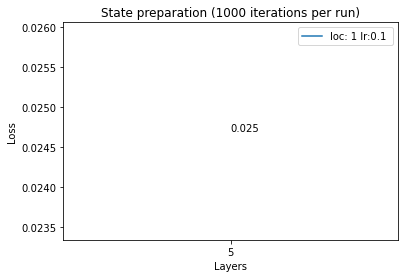

In [128]:
layers = [5]
results = {}
iterations = 1000

for locality in [1]:
    for lr in [0.1]:
        losses = []
        for l in layers:
            print(f"\n\nTraining with {l} layer(s) using start locality {locality}, {iterations} iterations, and {lr} learning rate:")
            qc = generate_state_preparation_circuit_swap_gates(qubits, l)
            random.seed(42)
            random_params = get_random_parameters_in_range(qc.parameters, 0, 2 * np.pi)
            (final_params, psi, loss) = train_with_locality(phi, qc, random_params, iterations, lr, locality, print_modulus=100)
            losses.append(loss)
        results[(locality, lr)] = losses.copy()
        
plt.title(f'State preparation ({iterations} iterations per run)')
for hp, losses in results.items():
    plt.plot(layers, losses, label=f"loc: {hp[0]} lr:{hp[1]} ")
    for i in range(len(losses)): plt.annotate(np.around(losses[i], 3), (layers[i], losses[i]))
plt.xlabel("Layers")
plt.ylabel("Loss")
plt.xticks(layers)
plt.legend()
plt.show()

### The global cost function approach did better for the same number of iterations than this approach with a local cost function.